In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant import xtdata
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
def caculate_returns(returns_df, row):
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算最大收益
    max_return = returns_df[row].max()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    print(f"最大回撤: {max_drawdown:.2%}")
    print(f"夏普比率: {sharpe_ratio:.2f}")
    print(f"总收益率: {total_return:.2%}")
    print(f"波动率: {volatility:.2%}")
    print(f"最大收益: {max_return:.2%}")
    print(f"总盈亏: {total_profit_loss:.2%}")

In [3]:
df = pd.read_csv(r'D:\workspace\TradeX\ezMoney\database\dwdx_fall_back0125.csv')

In [4]:
df.set_index('date', inplace=True)
df['cumulative_returns'] = (1 + df['return']).cumprod()
df['p_return'] = df['return'] * df['position']
df['p_cumulative_returns'] = (1 + df['p_return']).cumprod()
df['first_cumulative_returns'] = (1 + df['first_return']).cumprod()
df['p_first_return'] = df['first_return'] * df['position']
df['p_first_cumulative_returns'] = (1 + df['p_first_return']).cumprod()


In [5]:
df['p3_return'] = df['return'] * 0.3
df['p3_cumulative_returns'] = (1 + df['p3_return']).cumprod()
df['p3_first_return'] = df['first_return'] * 0.3
df['p3_first_cumulative_returns'] = (1 + df['p3_first_return']).cumprod()
df_g_zero = df[df['codes_num'] > 0]

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

In [7]:
df

,code,name,return,max_return,first_return,position,codes_num,cumulative_returns,p_return,p_cumulative_returns,first_cumulative_returns,p_first_return,p_first_cumulative_returns,p3_return,p3_cumulative_returns,p3_first_return,p3_first_cumulative_returns
date,,,,,,,,,,,,,,,,,
2024-07-31,NaN,low,0.000000,0.000000,0.000000,0.951766,0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2024-08-01,NaN,low,0.000000,0.000000,0.000000,1.000000,0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2024-08-02,603082,low,0.033478,0.033478,0.033478,0.927208,1,1.033478,0.031041,1.031041,1.033478,0.031041,1.031041,0.010043,1.010043,0.010043,1.010043
2024-08-05,NaN,low,0.000000,0.000000,0.000000,0.675140,0,1.033478,0.000000,1.031041,1.033478,0.000000,1.031041,0.000000,1.010043,0.000000,1.010043
2024-08-06,NaN,low,0.000000,0.000000,0.000000,0.551162,0,1.033478,0.000000,1.031041,1.033478,0.000000,1.031041,0.000000,1.010043,0.000000,1.010043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17,NaN,low,0.000000,0.000000,0.000000,0.560071,0,1.209963,0.000000,1.302483,1.306393,0.000000,1.333058,0.000000,1.072065,0.000000,1.097065
2025-01-20,NaN,low,0.000000,0.000000,0.000000,0.664101,0,1.209963,0.000000,1.302483,1.306393,0.000000,1.333058,0.000000,1.072065,0.000000,1.097065
2025-01-21,002291,low,-0.019461,-0.019461,-0.019461,0.363078,1,1.186416,-0.007066,1.293280,1.280969,-0.007066,1.323638,-0.005838,1.065806,-0.005838,1.090660


In [8]:
print("return:")
caculate_returns(df_g_zero, 'return')
print("p return:")
caculate_returns(df_g_zero, 'p_return')
print("first return:")
caculate_returns(df_g_zero, 'first_return')
print("p first_return:")
caculate_returns(df_g_zero, 'p_first_return')
print("p3 return:")
caculate_returns(df_g_zero, 'p3_return')
print("p3 first return:")
caculate_returns(df_g_zero, 'p3_first_return')

return:
最大回撤: -20.73%
夏普比率: 0.09
总收益率: 14.75%
波动率: 5.90%
最大收益: 16.11%
总盈亏: 11.40%
p return:
最大回撤: -13.76%
夏普比率: 0.19
总收益率: 28.26%
波动率: 3.91%
最大收益: 14.37%
总盈亏: 25.16%
first return:
最大回撤: -13.93%
夏普比率: 0.12
总收益率: 23.89%
波动率: 5.88%
最大收益: 16.11%
总盈亏: 20.55%
p first_return:
最大回撤: -13.74%
夏普比率: 0.20
总收益率: 31.27%
波动率: 3.85%
最大收益: 14.37%
总盈亏: 28.17%
p3 return:
最大回撤: -6.54%
夏普比率: 0.09
总收益率: 5.59%
波动率: 1.77%
最大收益: 4.83%
总盈亏: 4.58%
p3 first return:
最大回撤: -4.28%
夏普比率: 0.12
总收益率: 8.05%
波动率: 1.76%
最大收益: 4.83%
总盈亏: 7.04%


In [9]:
caculate_returns(df_g_zero, 'p_return')

最大回撤: -13.76%
夏普比率: 0.19
总收益率: 28.26%
波动率: 3.91%
最大收益: 14.37%
总盈亏: 25.16%


In [10]:
caculate_returns(df_g_zero, 'p_return')

最大回撤: -13.76%
夏普比率: 0.19
总收益率: 28.26%
波动率: 3.91%
最大收益: 14.37%
总盈亏: 25.16%


In [11]:
caculate_returns(df_g_zero, 'first_return')

最大回撤: -13.93%
夏普比率: 0.12
总收益率: 23.89%
波动率: 5.88%
最大收益: 16.11%
总盈亏: 20.55%


In [12]:
caculate_returns(df_g_zero, 'p_first_return')

最大回撤: -13.74%
夏普比率: 0.20
总收益率: 31.27%
波动率: 3.85%
最大收益: 14.37%
总盈亏: 28.17%


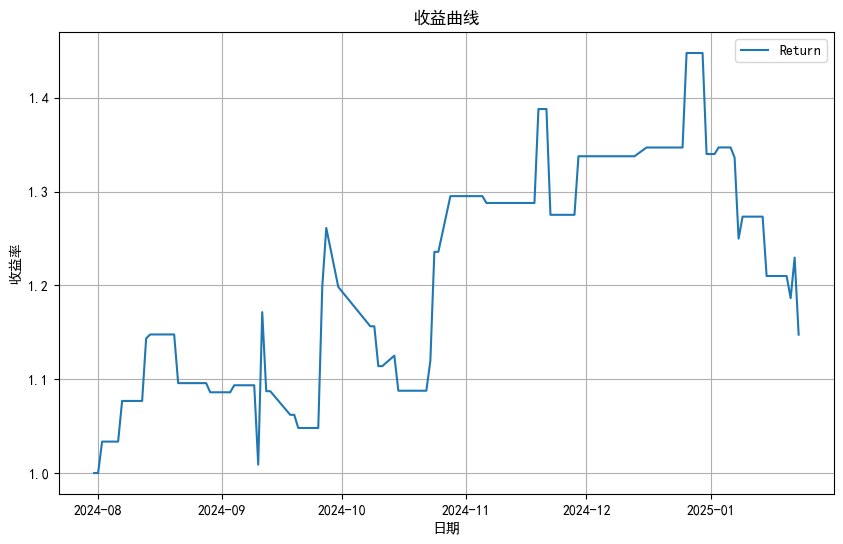

In [13]:
plot(df, 'cumulative_returns')

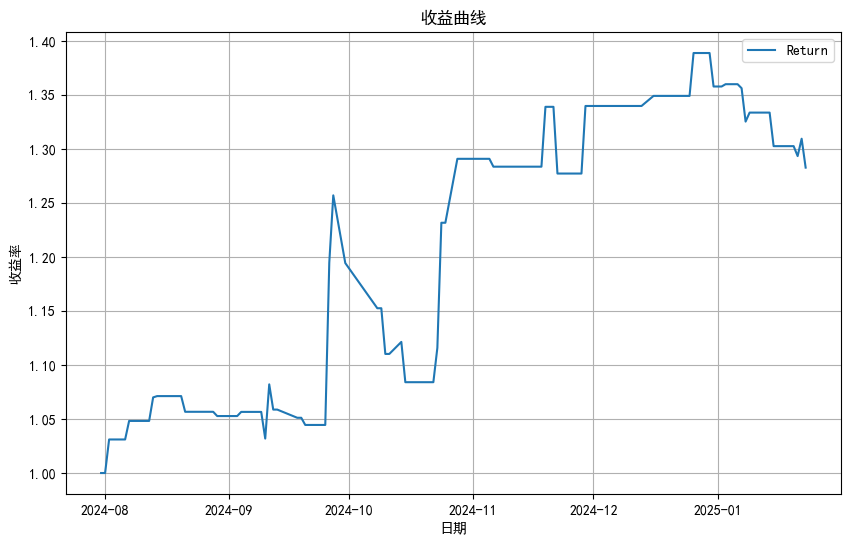

In [14]:
plot(df, 'p_cumulative_returns')

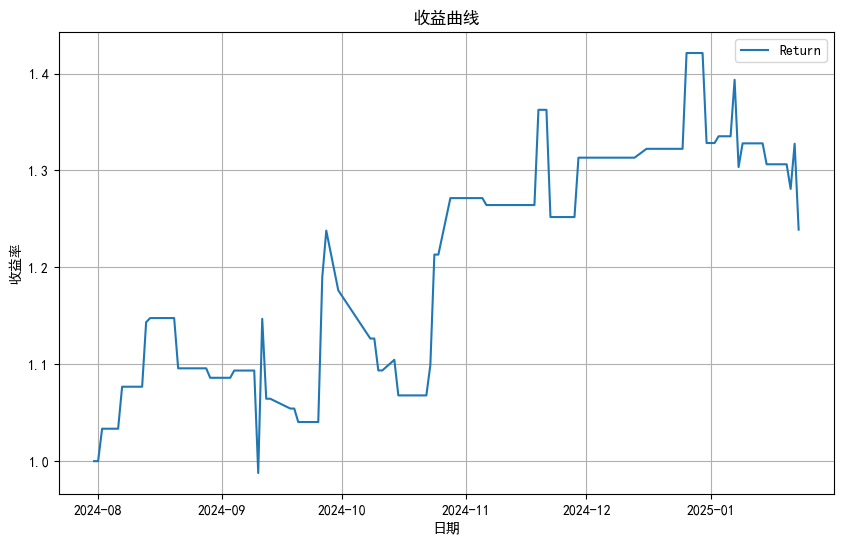

In [15]:
plot(df, 'first_cumulative_returns')

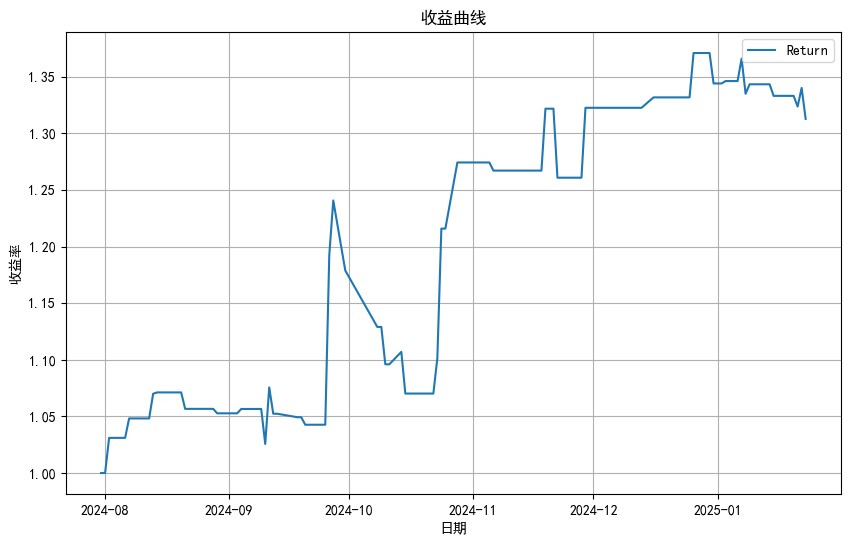

In [16]:
plot(df, 'p_first_cumulative_returns')

In [17]:
len(df_g_zero)

38

In [ ]:
len(df)

119

In [29]:
len(df)/len(df_g_zero)

3.1315789473684212

In [30]:
df_after_date = df.loc[df.index >= '2024-10-15']
df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
df_after_date['p_cumulative_returns'] = (1 + df_after_date['p_return']).cumprod()
df_after_date['first_cumulative_returns'] = (1 + df_after_date['first_return']).cumprod()
df_after_date['p_first_return'] = df_after_date['first_return'] * df_after_date['position']
df_after_date['p_first_cumulative_returns'] = (1 + df_after_date['p_first_return']).cumprod()
df_after_date_g_zero = df_after_date[df_after_date['codes_num'] > 0]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_38012\3002169448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['cumulative_returns'] = (1 + df_after_date['return']).cumprod()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38012\3002169448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_date['p_return'] = df_after_date['return'] * df_after_date['position']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38012\3002169448.py:4: SettingWithCopyWarning: 
A value is t

In [31]:
print("return:")
print(caculate_returns(df_after_date_g_zero, 'return'))
print("p return:")
print(caculate_returns(df_after_date_g_zero, 'p_return'))
print("first return:")
print(caculate_returns(df_after_date_g_zero, 'first_return'))
print("p first_return:")
print(caculate_returns(df_after_date_g_zero, 'p_first_return'))

return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None


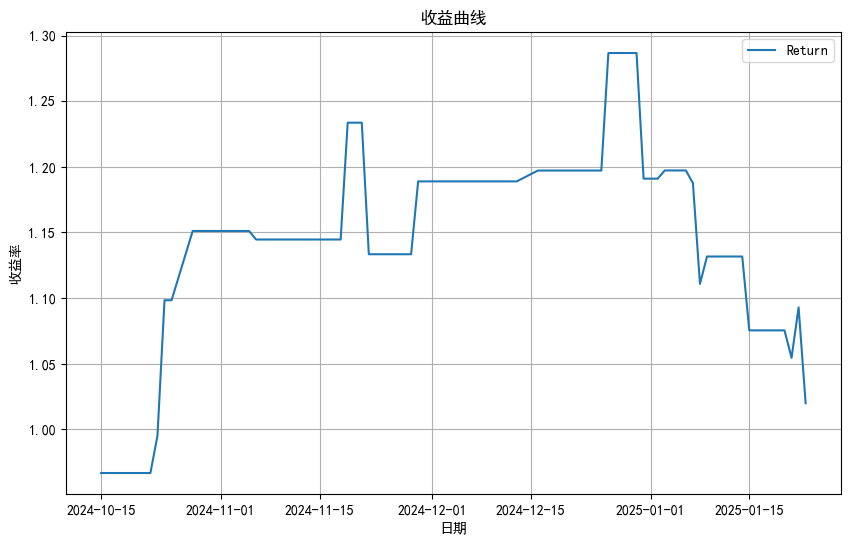

In [32]:
plot(df_after_date, 'cumulative_returns')

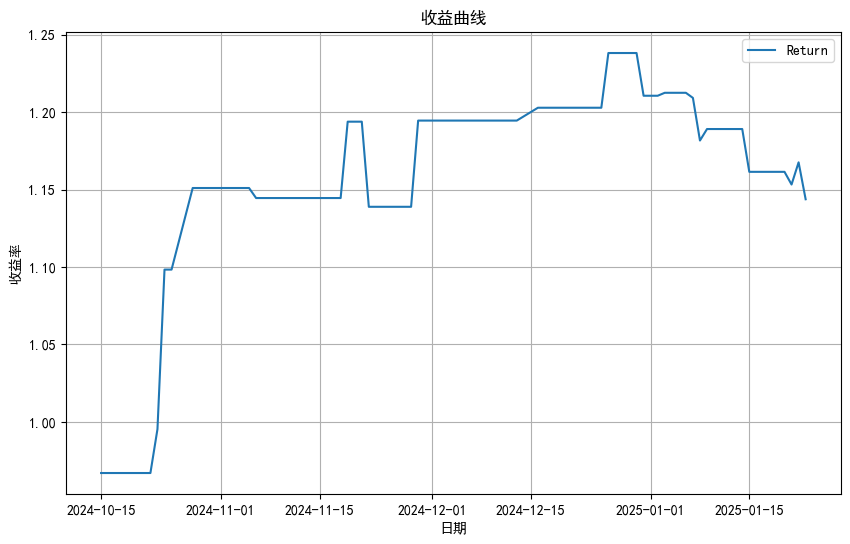

In [33]:
plot(df_after_date, 'p_cumulative_returns')

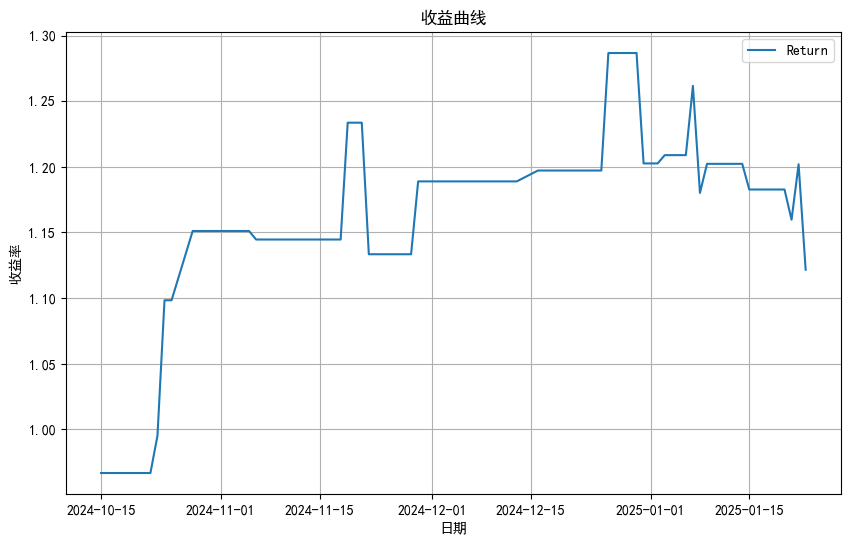

In [34]:
plot(df_after_date, 'first_cumulative_returns')

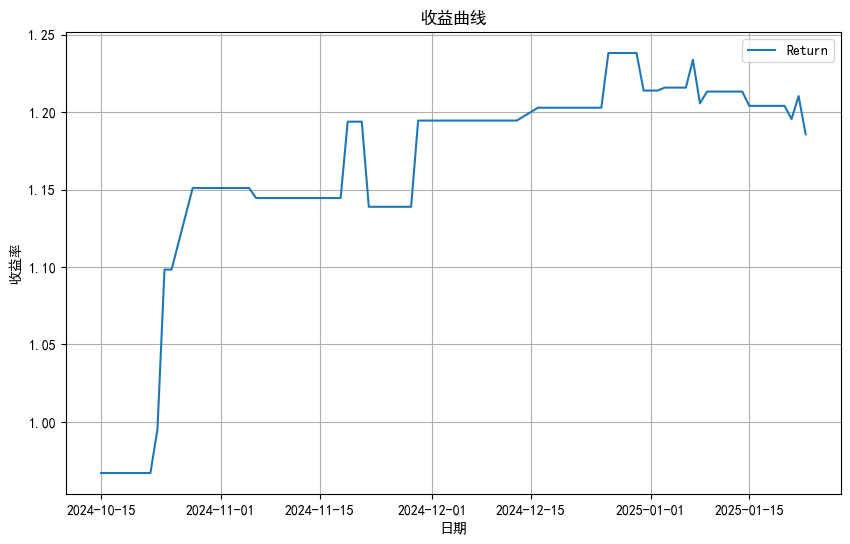

In [35]:
plot(df_after_date, 'p_first_cumulative_returns')

In [36]:
0.008906*0.3

0.0026718

In [25]:
3.61*0.3

1.083

In [26]:
df_g_zero

,code,name,return,max_return,first_return,position,codes_num,cumulative_returns,p_return,p_cumulative_returns,first_cumulative_returns,p_first_return,p_first_cumulative_returns,p3_return,p3_cumulative_returns,p3_first_return,p3_first_cumulative_returns
date,,,,,,,,,,,,,,,,,
2024-08-02,603082,low,0.033478,0.033478,0.033478,0.927208,1,1.033478,0.031041,1.031041,1.033478,0.031041,1.031041,0.010043,1.010043,0.010043,1.010043
2024-08-07,002278,low,0.041943,0.041943,0.041943,0.396782,1,1.076825,0.016642,1.048200,1.076825,0.016642,1.048200,0.012583,1.022753,0.012583,1.022753
2024-08-13,603375,low,0.061858,0.061858,0.061858,0.336042,1,1.143435,0.020787,1.069989,1.143435,0.020787,1.069989,0.018557,1.041732,0.018557,1.041732
2024-08-14,000901,low,0.003711,0.003711,0.003711,0.300000,1,1.147678,0.001113,1.071180,1.147678,0.001113,1.071180,0.001113,1.042892,0.001113,1.042892
2024-08-21,002388,low,-0.045198,-0.045198,-0.045198,0.300000,1,1.095806,-0.013559,1.056655,1.095806,-0.013559,1.056655,-0.013559,1.028751,-0.013559,1.028751
2024-08-29,603038,low,-0.008906,-0.008906,-0.008906,0.418266,1,1.086047,-0.003725,1.052719,1.086047,-0.003725,1.052719,-0.002672,1.026002,-0.002672,1.026002
2024-09-04,002514,low,0.006881,0.006881,0.006881,0.530514,1,1.093519,0.003650,1.056562,1.093519,0.003650,1.056562,0.002064,1.028120,0.002064,1.028120
2024-09-10,"603306,002104",low,-0.077367,-0.058020,-0.096714,0.301968,2,1.008917,-0.023363,1.031878,0.987760,-0.029205,1.025705,-0.023210,1.004257,-0.029014,0.998290
2024-09-11,600550,low,0.161130,0.161130,0.161130,0.301734,1,1.171483,0.048618,1.082046,1.146918,0.048618,1.075573,0.048339,1.052802,0.048339,1.046546


- **return**:
  - **最大回撤**: -20.73%
  - **夏普比率**: 0.09
  - **总收益率**: 14.75%
  - **波动率**: 5.90%
  - **最大收益**: 16.11%
  - **总盈亏**: 11.40%

- **p return**:
  - **最大回撤**: -13.76%
  - **夏普比率**: 0.19
  - **总收益率**: 28.26%
  - **波动率**: 3.91%
  - **最大收益**: 14.37%
  - **总盈亏**: 25.16%

- **first return**:
  - **最大回撤**: -13.93%
  - **夏普比率**: 0.12
  - **总收益率**: 23.89%
  - **波动率**: 5.88%
  - **最大收益**: 16.11%
  - **总盈亏**: 20.55%

- **p first_return**:
  - **最大回撤**: -13.74%
  - **夏普比率**: 0.20
  - **总收益率**: 31.27%
  - **波动率**: 3.85%
  - **最大收益**: 14.37%
  - **总盈亏**: 28.17%

- **p3 return**:
  - **最大回撤**: -6.54%
  - **夏普比率**: 0.09
  - **总收益率**: 5.59%
  - **波动率**: 1.77%
  - **最大收益**: 4.83%
  - **总盈亏**: 4.58%

- **p3 first return**:
  - **最大回撤**: -4.28%
  - **夏普比率**: 0.12
  - **总收益率**: 8.05%
  - **波动率**: 1.76%
  - **最大收益**: 4.83%
  - **总盈亏**: 7.04%


<!-- return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None -->


return:
最大回撤: -20.73%
夏普比率: 0.04
总收益率: 1.99%
波动率: 5.35%
最大收益: 10.37%
总盈亏: 5.31%
None
p return:
最大回撤: -7.64%
夏普比率: 0.21
总收益率: 14.38%
波动率: 3.52%
最大收益: 10.37%
总盈亏: 17.71%
None
first return:
最大回撤: -12.83%
夏普比率: 0.13
总收益率: 12.16%
波动率: 5.23%
最大收益: 10.37%
总盈亏: 15.49%
None
p first_return:
最大回撤: -4.61%
夏普比率: 0.26
总收益率: 18.58%
波动率: 3.44%
最大收益: 10.37%
总盈亏: 21.91%
None
